In [ ]:
%pip install -r requirements.txt

In [1]:
from ipywidgets import *
from vw_executor.vw_opts import VwOpts
from vw_executor.vw import Vw
import matplotlib.pyplot as plt

from pathlib import Path
import random
import pandas as pd
import json
import scipy
import numpy as np
import seaborn as sns
from playground.utils import cb_df, ccb_df, get_simulation, Metric
from playground.dashboard import Dashboard
from playground.vw_playground import VwPlayground
from playground.visualizers import new_ax, TrackIt, plot_reward

%matplotlib widget
sns.set_theme(style="darkgrid")

# CB

## Simulator

In [2]:
people = ['Tom', 'Anna']
topics = ['sports', 'politics']

def my_cb_simulation(n=10000, swap_after=5000, variance=0, bad_features=0):
    offset = 0
    for i in range(1, n):
        if i % swap_after == 0:
            offset = (offset + 1) % 2

        person = i % 2 
        chosen = i % 4  // 2 
        if (chosen + person + offset) % 2 == 0:
            reward =  0.7 + ((chosen + offset) % 2) * 0.1
        else:
            reward = 0.3 - ((chosen + offset + 1) % 2) * 0.1

        reward = reward + np.random.normal(0, variance)

        yield {
            "_label_cost": -reward,
            "_label_probability": 0.5,
            "_label_Action": chosen + 1,
            "_labelIndex": chosen,
            "a": [chosen + 1, (chosen + 1) % 2 + 1],
            "c": {'shared': {'name': people[person],
                '_multi': [
                    {'a': {'topic': topics[0]}, 'b': {f'f{i}': random.random() for i in range(int(bad_features))}},
                    {'a': {'topic': topics[1]}, 'b': {f'f{i}': random.random() for i in range(int(bad_features))}}]}},
            "p": [0.5, 0.5] 
        }

## Visualizers

In [3]:
def plot_env(examples, ax=None, window=100):
    ax = ax or new_ax()
    ax.set_title('Rewards')
    colors = ['green', 'red']
    styles = ['-', '-.']
    df = cb_df(examples)
    for i, p in enumerate(people):
        for j, t in enumerate(topics):
            d = df[['reward']][(df['person']==p) & (df['chosen']==j)].rolling(window=window).mean()
            sns.lineplot(x = d.index, y=d['reward'],
                         label=f'E(r|{p},{t})', color = colors[j], linestyle = styles[i], ax=ax,
                         errorbar=None, sort=False, estimator=None)       
    ax.legend()

    
def plot_probs(examples, job, ax=None, window=100):
    ax = ax or new_ax()
    ax.set_title('P(action|person)')
    ax.set_ylim(-0.05,1.05)
    colors = ['green', 'red']
    styles = ['-', '-.']
    df = pd.concat([cb_df(examples), pd.DataFrame(job[0].predictions('-p').cb)], axis=1)
    for i, p in enumerate(people):
        for j, t in enumerate(topics):
            d = df[(df['person']==p)][[str(j)]].rolling(window=window).mean() + i * 0.02
            sns.lineplot(x = d.index, y=d[str(j)],
                         label=f'P({t}|{p})',color = colors[j], linestyle = styles[i], ax=ax,
                         errorbar=None, sort=False, estimator=None)            
    ax.legend(loc='center left', bbox_to_anchor=(0.9, 0.5)) 
     

## Look at the data / Debug

In [ ]:
examples = my_cb_simulation(n=100, swap_after=50, variance = 0.1, bad_features = 1)
cb_df(examples).head()

In [ ]:
next(my_cb_simulation(n=10000, swap_after=5000, variance = 0, bad_features = 1))

In [ ]:
visualization = Dashboard(['-p'], [[plot_env, plot_probs]])
visualization.reset()
examples, examples_path = get_simulation('.data', my_cb_simulation, n = 10000, swap_after = 5000, variance = 0, bad_features = 1)
visualization.after_simulation(examples)
job = Vw('.cache', handler=None).train(examples_path, '--cb_explore_adf --dsjson -P 500', ['-p'])
visualization.after_train(examples, job)

## Interact

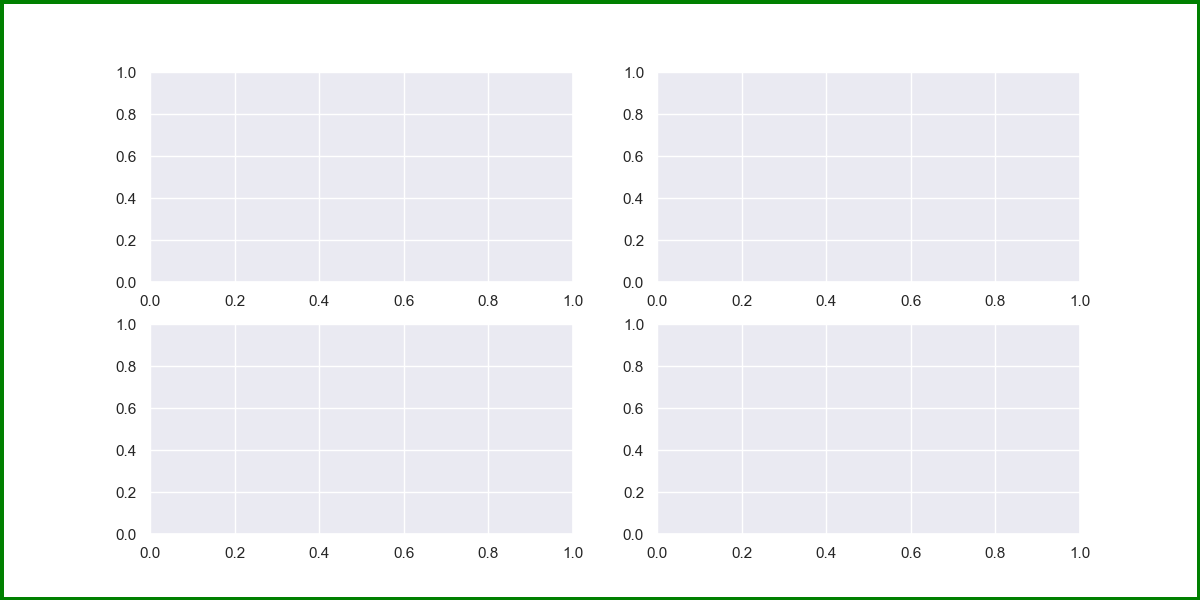

In [4]:
layout = [
    [plot_env, plot_probs],
    [plot_reward, TrackIt(Metric('average loss'), 'loss')]]

dashboard = Dashboard(['-p'], layout, figsize=(12,6))

playground = VwPlayground(my_cb_simulation, dashboard, vw_binary='vw')

playground.run(
    simulator_grid = {
        'n': IntSlider(value=10000, min=100, max=50000),
        'swap_after': IntSlider(value=5000, min=10, max=50000),
        'variance': FloatSlider(value=0, min=0, max=1, step=0.1),
        'bad_features': FloatLogSlider(value=1, min=0, max=10, base=2, step=1),
    },
    vw_grid = {
        '#base': fixed('--cb_explore_adf --dsjson --power_t 0 -P 1000 --log_output stderr'),
        '--learning_rate': FloatLogSlider(value=2**(-20), min=-20, max=10, base=2, step=1),
        '--cb_type': ['ips', 'mtr'],
        '--l1': FloatLogSlider(value=2**(-20), min=-20, max=10, base=2, step=1),
        '#interactions': ['', '-q sa', '-q ::'],
        '#exploration': ['--epsilon 0.1', '--squarecb', '--cover 5', '--synthcover']
    },
    columns=3
)

In [6]:
print(f'Last data file: {playground.examples_path}')
print(f'Last command line: {playground.last_job[0].args}')
print(f'Last exception: {playground.exception}')


Last data file: .cache\datasets\7824052458040826796\n-10000-swap_after-5000-variance-0.4-bad_features-32.0.json
Last command line: --cb_explore_adf --dsjson --power_t 0 -P 1000 --log_output stderr --learning_rate 0.0625 --cb_type mtr --l1 9.5367431640625e-07 -q :: --epsilon 0.1 -d .cache\datasets\7824052458040826796\n-10000-swap_after-5000-variance-0.4-bad_features-32.0.json -p .cache\cache-p\02e4382e3c934cc52eae1c25b37c1fe1 -f .cache\cache-f\02e4382e3c934cc52eae1c25b37c1fe1
Last exception: None


In [11]:
playground.last_job[0].stdout.raw

['creating quadratic features for pairs: sa\n',
 'using l1 regularization = 9.53674e-07\n',
 'final_regressor = .cache\\cache-f\\9c0c8e1636bf7c2db7f22a30571143ed\n',
 'predictions = .cache\\cache-p\\9c0c8e1636bf7c2db7f22a30571143ed\n',
 "[critical] vw (option_group_definition.cc:30): Error: 'ips' is not a valid choice for option --cb_type. Please select from {mtr}\n"]

# CCB

## Simulator

In [ ]:
import random
import numpy as np

people_ccb = ['Tom', 'Anna']
topics_ccb = ['sports', 'politics', 'music']

def my_ccb_simulation(n=10000, swap_after=5000, variance=0, bad_features=0, seed=0):
    random.seed(seed)
    np.random.seed(seed)

    envs = [
        [[0.8, 0.4, 0.2],
        [0.2, 0.4, 0.8]],
        [[0.2, 0.4, 0.8],
        [0.8, 0.2, 0.4]]]
    offset = 0
    for i in range(1, n):
        if i % swap_after == 0:
            offset = (offset + 1) % 2
        person = random.randint(0, 1)
        chosen = [int(i) for i in np.random.permutation(3)]
        rewards = [
            envs[offset][person][chosen[0]],
            envs[offset][person][chosen[1]]
            ]

        for i in range(len(rewards)):
            rewards[i] += np.random.normal(0, variance)

        yield {
            "c": {
                'shared': {'name': people_ccb[person]},
                '_multi': [{'a': {'topic': topics_ccb[i]}, 'b': {f'f{j}': random.random() for j in range(int(bad_features))}} for i in range(3)],
                '_slots': [{'_id': i} for i in range(2)]
            },
            '_outcomes': [{
                '_label_cost': -rewards[i],
                '_a': chosen[i:],
                '_p': [1.0 / (3 - i)] * (3 - i)
            } for i in range(2)]
        }

## Visualizers

In [ ]:
def plot_env_ccb(examples, ax=None, window=100):
    ax = ax or new_ax()
    ax.set_title('Rewards')
    colors = ['green', 'red', 'blue']
    styles = ['solid', 'dashed']
    df = ccb_df(examples)
    df = df[df['slot']==0]
    for i, p in enumerate(people_ccb):
        for j, t in enumerate(topics_ccb):
            d = df[['reward']][(df['person']==p) & (df['chosen']==j)].rolling(window=window).mean()
            sns.lineplot(x = d.index, y=d['reward'],
                         label=f'E(r|{p},{t})', color = colors[j], linestyle = styles[i], ax=ax,
                         errorbar=None, sort=False, estimator=None)       
    ax.legend()

## Look at the data / Debug

In [ ]:
examples = my_ccb_simulation(n=100, variance = 0.1, bad_features = 1, seed = 0)
ccb_df(examples).head()

In [ ]:
next(my_ccb_simulation(n=10000, variance = 0, bad_features = 1, seed = 0))

In [ ]:
visualization = Dashboard([], [[plot_env_ccb, plot_reward]])
visualization.reset()
examples, examples_path = get_simulation('.data', my_ccb_simulation, n = 10000, variance = 0, bad_features = 1, seed = 0)
visualization.after_simulation(examples)
job = Vw('.cache', handler=None).train(examples_path, '--ccb_explore_adf --dsjson', ['-p'])
visualization.after_train(examples, job)

## Interact

In [ ]:
layout = [
    [plot_env_ccb, lambda examples, job, ax: plot_reward(examples, job, ax, 10)]]

dashboard = Dashboard([], layout, figsize=(12,4))

playground = VwPlayground(my_ccb_simulation, dashboard)

playground.run(
    simulator_grid = {
        'n': IntSlider(value=10000, min=100, max=50000),
        'swap_after': IntSlider(value=5000, min=10, max=50000),
        'variance': FloatSlider(value=0, min=0, max=1, step=0.1),
        'bad_features': FloatLogSlider(value=1, min=0, max=10, base=2, step=1),
        'seed': IntSlider(value=0, min=0, max=100)
    },
    vw_grid = {
        '#base': fixed('--ccb_explore_adf --dsjson --power_t 0 -P 100'),
        '--learning_rate': FloatLogSlider(value=2**(-20), min=-20, max=10, base=2, step=1),
        '--cb_type': ['ips', 'mtr'],
        '--l1': FloatLogSlider(value=2**(-20), min=-20, max=10, base=2, step=1),
        '#noconstant': ['', '--noconstant'],
        '#config': ['', '-q sa', '-q ::', '--automl 4 --automl_alpha 0.01 --global_lease 4000 --oracle_type one_diff --priority_challengers 1'],
    },
    columns=3
)

In [ ]:
print(f'Last data file: {playground.examples_path}')
print(f'Last command line: {playground.last_job[0].args}')
print(f'Last exception: {playground.exception}')

In [ ]:
playground.last_job[0].stdout.raw